In [18]:
%aiida
from BigDFT import Datasets as D,Inputfiles as I, AiidaCalculator as C
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [22]:
benchmarks_path="/home/aiida/Irene/"
filename="1YNT.pdb"

from BigDFT.IO import read_pdb
sys = read_pdb(open(filename))

charge = -5

nodelist=[64, 96, 128, 192, 256]
mpilist=[16]
omplist=[8]

In [23]:
#Limit nb of iterations for this set
from BigDFT.Inputfiles import Inputfile
inp = Inputfile()
inp.set_xc("PBE")
inp.set_hgrid(0.4)
inp.charge(charge)
inp["import"] = "linear"
inp['lin_general'] = {'calc_dipole' : True, 'output_mat': 0}
inp['perf'] = {'check_sumrho': 0, 'check_overlap': 0}

In [24]:
benchData=D.Dataset(label='bench-1YNT',input=inp, posinp=sys.get_posinp(), queue_name='rome', asynchronous=True)

In [25]:
#append MPi and OMP
# 12000s for 32 nodes for Luigi's run -> scaling not perfect, so ask twice that.
for nodes in nodelist:
    for mpi in mpilist:
        for omp in omplist:
            wtime=int(48000*32/nodes)
            print(str(wtime)+" max walltime for "+str(nodes)+" nodes")
            code=C.AiidaCalculator(code="bigdft@irene2",num_machines=nodes,mpiprocs_per_machine=mpi,omp=omp, walltime=wtime)
            id={'name':'1YNT', 'nodes':nodes,'mpi':mpi,'omp':omp}
            benchData.append_run(id=id,runner=code)



24000 max walltime for 64 nodes
Initialize an Aiida Calculator for Remote code 'bigdft' on irene2, pk: 146, uuid: ae6aeea2-26f4-4dc4-9f83-a4ff2667a644 with 64 machine(s) , 16 processes per machine, and 8 cores per process
16000 max walltime for 96 nodes
Initialize an Aiida Calculator for Remote code 'bigdft' on irene2, pk: 146, uuid: ae6aeea2-26f4-4dc4-9f83-a4ff2667a644 with 96 machine(s) , 16 processes per machine, and 8 cores per process
12000 max walltime for 128 nodes
Initialize an Aiida Calculator for Remote code 'bigdft' on irene2, pk: 146, uuid: ae6aeea2-26f4-4dc4-9f83-a4ff2667a644 with 128 machine(s) , 16 processes per machine, and 8 cores per process
8000 max walltime for 192 nodes
Initialize an Aiida Calculator for Remote code 'bigdft' on irene2, pk: 146, uuid: ae6aeea2-26f4-4dc4-9f83-a4ff2667a644 with 192 machine(s) , 16 processes per machine, and 8 cores per process
6000 max walltime for 256 nodes
Initialize an Aiida Calculator for Remote code 'bigdft' on irene2, pk: 146, u

In [26]:
def get_time(DS):
    from os import path as p
    from futile import Time as T
    datadir=DS.fetch_results(attribute='data_directory')
    run_dir=DS.get_global_option('run_dir')
    print(run_dir, datadir)
    time_files=[ p.join(run_dir,d,'time-'+n+'.yaml') for d,n in zip(datadir,DS.names)]
    print(time_files)
    return T.TimeData(*time_files)

In [27]:
tt=benchData.run()

Creating the yaml input file "./mpi:16,name:1YNT,nodes:64,omp:8.yaml"
Creating the yaml input file "./mpi:16,name:1YNT,nodes:96,omp:8.yaml"
Creating the yaml input file "./mpi:16,name:1YNT,nodes:128,omp:8.yaml"
Creating the yaml input file "./mpi:16,name:1YNT,nodes:192,omp:8.yaml"
Creating the yaml input file "./mpi:16,name:1YNT,nodes:256,omp:8.yaml"


Channel <Channel number=1 CLOSED conn=<TornadoConnection CLOSED transport=None params=<ConnectionParameters host=127.0.0.1 port=5672 virtual_host=/ ssl=False>>> closed: No activity or too many missed heartbeats in the last 60 seconds
Channel <Channel number=2 CLOSED conn=<TornadoConnection CLOSED transport=None params=<ConnectionParameters host=127.0.0.1 port=5672 virtual_host=/ ssl=False>>> closed: No activity or too many missed heartbeats in the last 60 seconds
Channel <Channel number=3 CLOSED conn=<TornadoConnection CLOSED transport=None params=<ConnectionParameters host=127.0.0.1 port=5672 virtual_host=/ ssl=False>>> closed: No activity or too many missed heartbeats in the last 60 seconds
Channel <Channel number=4 CLOSED conn=<TornadoConnection CLOSED transport=None params=<ConnectionParameters host=127.0.0.1 port=5672 virtual_host=/ ssl=False>>> closed: No activity or too many missed heartbeats in the last 60 seconds
10/15/2020 08:27:47 AM <16022> tornado.application: [ERROR] Futu

Wait for completion of all jobs.

In [28]:
def wait_ds(DS):
    from IPython.display import display, clear_output

    running=len(DS.results)
    while(running!=0):

        import time
        time.sleep(1)
        running=len(DS.results)
        for c in DS.results:
            pk=DS.results[c]['node'].pk
            node=load_node(pk)
            if(node.is_finished):
                running-=1
                #print(node.is_finished_ok)
        clear_output(wait=True)
        display(str(running)+" processes still running")


Collect the logfiles

In [29]:
def get_logfiles(DS):
    logfiles={}
    for c in DS.results:
        print(DS.results[c]['node'].pk)
        try:
            logfiles[c]=DS.calculators[0]['calc'].get_logs(DS.results[c]['node'].pk,DS.names[c])
        except:
            logfiles[c]=DS.results[c]
            print("no logfile for "+ str(c))
    return logfiles

In [30]:
%%notify
wait_ds(benchData)

'0 processes still running'

<IPython.core.display.Javascript object>

In [31]:
logfiles=get_logfiles(benchData)

396
setting data dir to /home/aiida/.aiida/repository/default/repository/node/a3/77/3cf2-0cd8-4e3c-8940-55dcc85eebb7/path
400
setting data dir to /home/aiida/.aiida/repository/default/repository/node/cb/f7/8cff-6a36-42d2-afb4-32b9e7ffa5f5/path
404
setting data dir to /home/aiida/.aiida/repository/default/repository/node/82/99/3f8a-8f42-49fa-8459-a8c45fd4e616/path
408
setting data dir to /home/aiida/.aiida/repository/default/repository/node/2a/d6/c510-8957-4bf5-878f-9f6b457b2465/path
412
setting data dir to /home/aiida/.aiida/repository/default/repository/node/4b/33/1a22-434f-4719-bd3b-57afc63e9472/path


In [44]:
print(benchData.results[3])

- Atom types:
  - N
  - C
  - O
  - H
  - S
  - Zn
- cell: Free BC
- number_of_orbitals: 18167
- XC_parameter: -101130
- grid_spacing: 0.4
- spin_polarization: 1
- total_magn_moment: 0
- system_charge: -15
- rmult:
  - 5.0
  - 8.0
- dipole:
  - 82.196
  - 18.1275
  - -88.91763
- energy: -58931.87603607029
- forcemax: 0.1418870817161
- forcemax_cv: 0.0
- gnrm_cv: 0.0001
- nat: 12898
- symmetry: disabled



Using matplotlib backend: module://ipympl.backend_nbagg
runs ['/home/aiida/.aiida/repository/default/repository/node/a3/77/3cf2-0cd8-4e3c-8940-55dcc85eebb7/path', '/home/aiida/.aiida/repository/default/repository/node/cb/f7/8cff-6a36-42d2-afb4-32b9e7ffa5f5/path', '/home/aiida/.aiida/repository/default/repository/node/82/99/3f8a-8f42-49fa-8459-a8c45fd4e616/path', '/home/aiida/.aiida/repository/default/repository/node/2a/d6/c510-8957-4bf5-878f-9f6b457b2465/path', '/home/aiida/.aiida/repository/default/repository/node/4b/33/1a22-434f-4719-bd3b-57afc63e9472/path']
['/home/aiida/.aiida/repository/default/repository/node/a3/77/3cf2-0cd8-4e3c-8940-55dcc85eebb7/path/time-mpi:16,name:1YNT,nodes:64,omp:8.yaml', '/home/aiida/.aiida/repository/default/repository/node/cb/f7/8cff-6a36-42d2-afb4-32b9e7ffa5f5/path/time-mpi:16,name:1YNT,nodes:96,omp:8.yaml', '/home/aiida/.aiida/repository/default/repository/node/82/99/3f8a-8f42-49fa-8459-a8c45fd4e616/path/time-mpi:16,name:1YNT,nodes:128,omp:8.yaml', '/

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

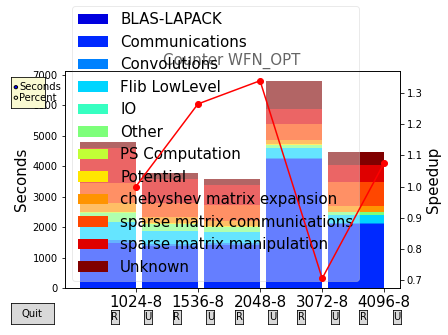

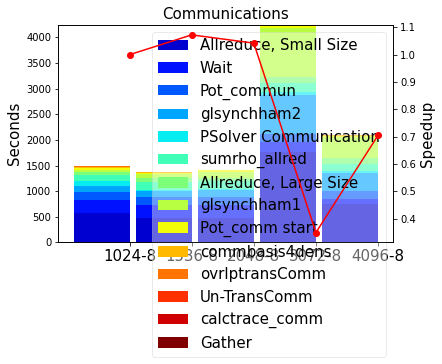

In [37]:
%matplotlib auto
import futile
from futile import Time
tt=get_time(benchData)
tt2=tt.inspect_category("Communications")

In [34]:
tt2=tt.inspect_category("PS Computation")

In [15]:
print(tt.totals)

[596.0, 364.0, 311.0]
